## nb to test best params got by finetuning

In [ ]:
import sys
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt
import time
import numpy as np
from tqdm import tqdm
from scipy.sparse import issparse


In [2]:
# Import the required functions from the problem module
from problem import get_train_data, get_test_data

# Load the training and testing data
X_train, y_train = get_train_data()
X_test, y_test = get_test_data()

X_all = np.vstack([X_train.toarray(), X_test.toarray()])
y_all = np.hstack([y_train, y_test])

In [3]:
class HVGSelector:
    def __init__(self, n_hvg=2000):
        self.n_hvg = n_hvg

    def fit(self, X):
        mean = X.mean(axis=0)
        var = X.var(axis=0)

        dispersion = var / (mean + 1e-6)
        self.idx_ = np.argsort(dispersion)[-self.n_hvg:]
        return self

    def transform(self, X):
        return X[:, self.idx_]

In [4]:
def preprocess(self,X):
    if issparse(X):
        X = X.toarray()

    # library size normalization
    libsize = X.sum(axis=1, keepdims=True)
    libsize[libsize == 0] = 1.0
    X = X / libsize * 1e4

    # log transform
    X = np.log1p(X)
    return X

In [5]:
def evaluate_model(
    X, y,
    n_hvg,
    learning_rate,
    max_depth,
    max_leaf_nodes,
    min_samples_leaf,
    l2_regularization,
    n_splits=5
):
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=0
    )

    scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_va = X[train_idx], X[val_idx]
        y_tr, y_va = y[train_idx], y[val_idx]

        # preprocessing
        X_tr = preprocess(X_tr)
        X_va = preprocess(X_va)

        # HVG
        hvg = HVGSelector(n_hvg=n_hvg)
        hvg.fit(X_tr)
        X_tr = hvg.transform(X_tr)
        X_va = hvg.transform(X_va)

        # sample weights
        sw = compute_sample_weight("balanced", y_tr)

        # model
        model = HistGradientBoostingClassifier(
            learning_rate=learning_rate,
            max_depth=max_depth,
            max_leaf_nodes=max_leaf_nodes,
            min_samples_leaf=min_samples_leaf,
            l2_regularization=l2_regularization,
            early_stopping=True,
            random_state=0
        )

        model.fit(X_tr, y_tr, sample_weight=sw)
        y_pred = model.predict(X_va)

        score = balanced_accuracy_score(y_va, y_pred)
        scores.append(score)

    return np.mean(scores), np.std(scores)


In [6]:
param_space = {
    "n_hvg": [1000, 2000, 3000, 5000],
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "max_leaf_nodes": [15, 30, 60],
    "min_samples_leaf": [10, 30, 50],
    "l2_regularization": [0.0, 0.5, 1.0],
}


In [7]:
import random

n_trials = 30  # ajustable
results = []

keys = list(param_space.keys())

for _ in tqdm(range(n_trials)):
    params = {k: random.choice(param_space[k]) for k in keys}

    mean_score, std_score = evaluate_model(
        X_train, y_train,
        **params
    )

    results.append({
        **params,
        "mean_bal_acc": mean_score,
        "std": std_score
    })


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
import pandas as pd
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(
    by="mean_bal_acc",
    ascending=False
)

df_results.head(10)


In [ ]:
df_results[
    df_results["std"] < 0.03
].head(5)


In [ ]:
best_params = df_results.iloc[0].to_dict()
best_params


In [7]:
def preprocess(X, method='none'):
    """
    Convertit la matrice sparse en dense
    Normalisation : chaque cellule a une somme = 1
    """
    if not isinstance(X, np.ndarray):
        X = X.toarray()
    if method == 'none':
        pass
    elif method == 'normalize':
        X = X / X.sum(axis=1)[:, np.newaxis]
    elif method == 'log':
        X = np.log1p(X)
    else:
        raise ValueError("Unknown preprocessing method: {}".format(method))
    return X

In [8]:
class Classifier(object):
    def __init__(self, **kwargs):
        # Use scikit-learn's pipeline
        self.pipe = xgboost_pipeline(scaler=kwargs.get('scaler'), 
                                     pca_n_components=kwargs.get('pca_n_components'),
                                     max_depths=kwargs.get('max_depths'),
                                     max_features=kwargs.get('max_features'))
        
        self.kwargs = kwargs

    def fit(self, X_sparse, y):
        X, y = resampling(X_sparse, y, method=self.kwargs.get('resampling_method', 'none'))
        X = preprocess(X, method=self.kwargs.get('preprocessing_method', 'none'))
        self.pipe.fit(X, y)

        pass

    def predict_proba(self, X_sparse):
        X = preprocess(X_sparse, method=self.kwargs.get('preprocessing_method', 'none'))
        return self.pipe.predict_proba(X)
    
    def predict(self, X_sparse):
        X = preprocess(X_sparse, method=self.kwargs.get('preprocessing_method', 'none'))
        return self.pipe.predict(X)


In [9]:
clf = Classifier(scaler=False, 
                 pca_n_components=50,
                 max_depths=6,
                 max_features=1.0,
                 resampling_method='borderline_smote',
                 preprocessing_method='log')
clf.fit(X_train, y_train)

y_tr_pred = clf.predict(X_train)
y_te_pred = clf.predict(X_test)

In [10]:
def k_fold_fit_eval(clf, X, y, n_splits=5):
    from sklearn.model_selection import KFold

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    start_time = time.time()

    for train_index, test_index in kf.split(X):
        X_train, X_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)

        accuracy = balanced_accuracy_score(y_val, y_pred)
        accuracies.append(accuracy)

    end_time = time.time()
    avg_accuracy = np.mean(accuracies)
    fitting_time = end_time - start_time

    return avg_accuracy, fitting_time

In [11]:
k_fold_fit_eval(clf, X_all, y_all, n_splits=5)

(0.8395263441710693, 31.994942665100098)

Train balanced accuracy : 1.000
Test balanced accuracy : 0.821


Text(0.5, 1.0, 'Confusion matrix on test set')

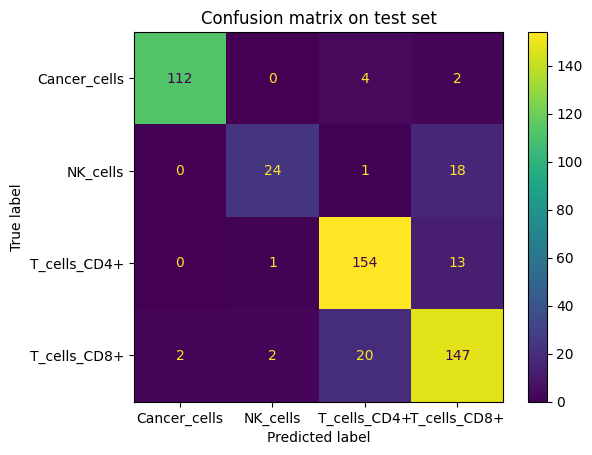

In [13]:
# compute balanced accuracy and confusion matrix
print(f"Train balanced accuracy : {balanced_accuracy_score(y_train, y_tr_pred):.3f}")
print(f"Test balanced accuracy : {balanced_accuracy_score(y_test, y_te_pred):.3f}")
cm = confusion_matrix(y_test, y_te_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.pipe.classes_, )
disp.plot()
plt.title("Confusion matrix on test set")

In [ ]:
!ramp-test --submission xgboost_classifier